In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

C:\Users\Name\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Topics
 - Sensitivity and Specificity
 - ROC Curves
 - Selecting optimal sensitivity and sensitivity
 - Hyperparamater tuning
 - other techniques to improve the performance of model

In [2]:
credit = pd.read_csv('https://raw.githubusercontent.com/skathirmani/datasets/master/credit-default.csv')
credit_dummies = pd.get_dummies(credit)

In [3]:
train,test = train_test_split(credit_dummies,test_size=0.3,random_state=100)
train_x= train.drop('default',axis=1)
test_x= test.drop('default',axis=1)
train_y= train['default']
test_y=test['default']

In [35]:
test_pred = np.ones(test_x.shape[0])

In [36]:
df_pred = pd.DataFrame({'actual':test_y,'predicted':test_pred})
df_pred['pred_status']=df_pred['actual'] ==df_pred['predicted']
dt_accuracy=df_pred[df_pred['pred_status']==True].shape[0] / df_pred.shape[0] *100
dt_accuracy

73.0

In [37]:
tn,fp,fn,tp = confusion_matrix(df_pred['actual'],df_pred['predicted'],labels=[1,2]).ravel()
tn,fp,fn,tp

(219, 0, 81, 0)

- in a balanced class specificity is high
- negative - 1 - non default
- positive - 2 - default


In [6]:
#by taking all predicted values as 2
test_pred = np.ones(test_x.shape[0])*2
df_pred = pd.DataFrame({'actual':test_y,'predicted':test_pred})
df_pred['pred_status']=df_pred['actual'] ==df_pred['predicted']
dt_accuracy=df_pred[df_pred['pred_status']==True].shape[0] / df_pred.shape[0] *100
dt_accuracy
tn,fp,fn,tp = confusion_matrix(df_pred['actual'],df_pred['predicted'],labels=[1,2]).ravel()
tn,fp,fn,tp


(0, 219, 0, 81)

In [7]:
model = RandomForestClassifier(random_state=100)
model.fit(train_x,train_y)
test_pred =model.predict(test_x)
accuracy_score(test_y,test_pred)

0.76

In [31]:
df_pred = pd.DataFrame({'actual':test_y,'predicted':test_pred})
df_pred['pred_status']=df_pred['actual'] ==df_pred['predicted']
dt_accuracy=df_pred[df_pred['pred_status']==True].shape[0] / df_pred.shape[0] *100
dt_accuracy

76.0

In [32]:
tn,fp,fn,tp = confusion_matrix(df_pred['actual'],df_pred['predicted'],labels=[1,2]).ravel()
tn,fp,fn,tp

(200, 19, 53, 28)

In [38]:
28/(28+53)

0.345679012345679

In [39]:
200/(200+19)

0.91324200913242

In [8]:
probs =pd.DataFrame(model.predict_proba(test_x),columns=['Neg_1','Pos_2'])
probs.head()

,Neg_1,Pos_2
0,0.5,0.5
1,0.1,0.9
2,0.7,0.3
3,0.3,0.7
4,0.6,0.4


In [9]:
cut_off =0.3
test_pred2= probs['Pos_2'].apply(lambda v:2 if v >cut_off else 1)
tn,fp,fn,tp = confusion_matrix(test_y,test_pred2,labels=[1,2]).ravel()
sensitivity =tp/(tp+fn)
specificity= tn/(tn+fp)
print('cut-off  %.2f, sensitivity %.1f ,specificity %.1f'  %(cut_off, sensitivity *100,specificity *100))

cut-off  0.30, sensitivity 65.4 ,specificity 70.3


- sensitivity - true positive rate
- 1- specificity - false positive rate
- 1 model 1 ROC curve

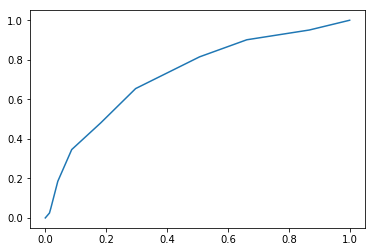

In [12]:
from sklearn.metrics import roc_curve
fpr,tpr,cutoffs = roc_curve(test_y,probs['Pos_2'],pos_label=2)
plt.plot(fpr,tpr)

[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0]
-----
[0.9506172839506173, 0.9012345679012346, 0.8148148148148148, 0.654320987654321, 0.48148148148148145, 0.345679012345679, 0.18518518518518517, 0.04938271604938271, 0.024691358024691357, 0.0, 0.0]
-----
[0.8675799086757991, 0.6621004566210046, 0.5068493150684932, 0.29680365296803657, 0.182648401826484, 0.08675799086757996, 0.04109589041095896, 0.0182648401826484, 0.013698630136986356, 0.0, 0.0]


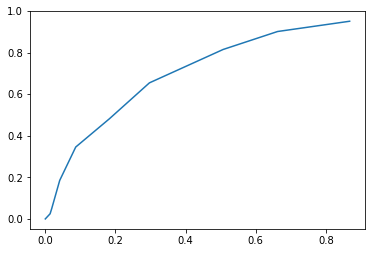

In [10]:
cut_offs = []
tpr=[]
fpr=[]
for cut_off in np.linspace(0,1,11):
    test_pred2= probs['Pos_2'].apply(lambda v:2 if v >cut_off else 1)
    tn,fp,fn,tp = confusion_matrix(test_y,test_pred2,labels=[1,2]).ravel()
    sensitivity =tp/(tp+fn)
    specificity= tn/(tn+fp)
    cut_offs.append(cut_off)
    tpr.append(sensitivity)
    fpr.append(1-specificity)
print(cut_offs)
print('-----')
print(tpr)
print('-----')
print(fpr)
plt.plot(fpr,tpr)

In [96]:
df_roc =pd.DataFrame({
    'cutoff':cutoffs,
    'fpr':fpr,
    'tpr':tpr,
    'specificity':1-fpr

})
df_roc['youden_index'] =df_roc['tpr']  + df_roc ['specificity'] -1
df_roc.sort_values(by='youden_index',ascending=False)

,cutoff,fpr,specificity,tpr,youden_index
6,0.4,0.296804,0.703196,0.654321,0.357517
7,0.3,0.506849,0.493151,0.814815,0.307965
5,0.5,0.182648,0.817352,0.481481,0.298833
4,0.6,0.086758,0.913242,0.345679,0.258921
8,0.2,0.662100,0.337900,0.901235,0.239134
3,0.7,0.041096,0.958904,0.185185,0.144089
9,0.1,0.867580,0.132420,0.950617,0.083037
2,0.8,0.018265,0.981735,0.049383,0.031118
1,0.9,0.013699,0.986301,0.024691,0.010993
0,1.9,0.000000,1.000000,0.000000,0.000000


In [98]:
test_pred_new = probs['Pos_2'].apply(lambda v :2 if v>0.4 else 1)

Random Forest AUC: 0.75
Adaptive Boosting AUC: 0.74
Decision Tree AUC: 0.65


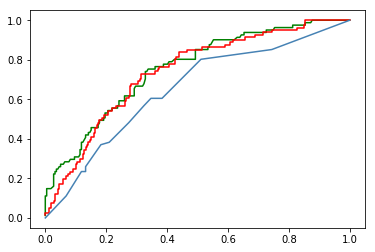

In [109]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
model1 = RandomForestClassifier(random_state=100,n_estimators=1000)
model1.fit(train_x,train_y)
probs1 = pd.DataFrame(model1.predict_proba(test_x),columns=['Neg_1','Pos_2'])
fpr,tpr,cutoffs = roc_curve(test_y,probs1['Pos_2'],pos_label=2)
auc_rf =auc(fpr,tpr)
plt.plot(fpr,tpr,color='green')

print('Random Forest AUC: %.2f' % auc_rf)
from sklearn.ensemble import AdaBoostClassifier
model2 = AdaBoostClassifier(random_state=100)
model2.fit(train_x,train_y)
probs2 = pd.DataFrame(model2.predict_proba(test_x),columns=['Neg_1','Pos_2'])
fpr,tpr,cutoffs = roc_curve(test_y,probs2['Pos_2'],pos_label=2)
auc_ab =auc(fpr,tpr)
plt.plot(fpr,tpr,color='red')

print('Adaptive Boosting AUC: %.2f' % auc_ab)

from sklearn.tree import DecisionTreeClassifier
model3 = DecisionTreeClassifier(random_state=100,max_depth=7)
model3.fit(train_x,train_y)
probs3 = pd.DataFrame(model3.predict_proba(test_x),columns=['Neg_1','Pos_2'])
fpr,tpr,cutoffs = roc_curve(test_y,probs3['Pos_2'],pos_label=2)
auc_dt=auc(fpr,tpr)
plt.plot(fpr,tpr,color='steelblue')
print('Decision Tree AUC: %.2f' % auc_dt)

# for HR data

In [166]:
hr = pd.read_csv('HR Analytics.csv')
hr_dummies=pd.get_dummies(hr)
train,test =train_test_split(hr_dummies,test_size=0.3,random_state=100)
train_y =train['Attrition']
test_y = test['Attrition']
train_x=train.drop('Attrition',axis=1)
test_x=test.drop('Attrition',axis=1)

Random Forest AUC: 0.76
Adaptive Boosting AUC: 0.78
Decision Tree AUC: 0.60


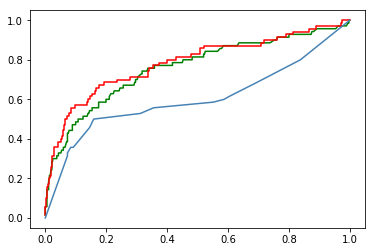

In [167]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
model1 = RandomForestClassifier(random_state=100,n_estimators=1000)
model1.fit(train_x,train_y)
probs1 = pd.DataFrame(model1.predict_proba(test_x),columns=['Neg_1','Pos_2'])
fpr,tpr,cutoffs = roc_curve(test_y,probs1['Pos_2'],pos_label=1)
auc_rf =auc(fpr,tpr)
plt.plot(fpr,tpr,color='green')

print('Random Forest AUC: %.2f' % auc_rf)
from sklearn.ensemble import AdaBoostClassifier
model2 = AdaBoostClassifier(random_state=100)
model2.fit(train_x,train_y)
probs2 = pd.DataFrame(model2.predict_proba(test_x),columns=['Neg_1','Pos_2'])
fpr,tpr,cutoffs = roc_curve(test_y,probs2['Pos_2'],pos_label=1)
auc_ab =auc(fpr,tpr)
plt.plot(fpr,tpr,color='red')

print('Adaptive Boosting AUC: %.2f' % auc_ab)

from sklearn.tree import DecisionTreeClassifier
model3 = DecisionTreeClassifier(random_state=100,max_depth=7)
model3.fit(train_x,train_y)
probs3 = pd.DataFrame(model3.predict_proba(test_x),columns=['Neg_1','Pos_2'])
fpr,tpr,cutoffs = roc_curve(test_y,probs3['Pos_2'],pos_label=1)
auc_dt=auc(fpr,tpr)
plt.plot(fpr,tpr,color='steelblue')
print('Decision Tree AUC: %.2f' % auc_dt)

In [168]:
from sklearn.ensemble import AdaBoostClassifier
model2 = AdaBoostClassifier(random_state=100)
model2.fit(train_x,train_y)
probs2 = pd.DataFrame(model2.predict_proba(test_x),columns=['Neg_1','Pos_2'])
fpr,tpr,cutoffs = roc_curve(test_y,probs2['Pos_2'],pos_label=1)

auc_ab =auc(fpr,tpr)

df_roc = pd.DataFrame({
    'sensitivity': tpr,
    'specificity': 1- fpr,
    'cutoff': cutoffs
})
df_roc['youden_index'] = df_roc['sensitivity'] + df_roc['specificity'] -1
df_roc.sort_values(by='youden_index', ascending=False).head(1)

,cutoff,sensitivity,specificity,youden_index
55,0.492063,0.671429,0.822102,0.493531


In [169]:
from sklearn.metrics import accuracy_score,classification_report
cut_off = 0.49
test_pred_new =probs2['Pos_2'].apply(lambda v:1 if v>cut_off else 0)
print(accuracy_score(test_y,test_pred_new))
print(classification_report(test_y,test_pred_new))


0.7551020408163265
             precision    recall  f1-score   support

          0       0.93      0.77      0.84       371
          1       0.36      0.70      0.48        70

avg / total       0.84      0.76      0.78       441



# for Bank Data

In [155]:

bank =pd.read_csv('bank-full.csv',sep=';')
bank_temp=bank.drop('y',axis=1)
bank_dummies=pd.get_dummies(bank_temp)
bank_dummies['y']=bank['y']
train,test =train_test_split(bank_dummies,test_size=0.3,random_state=100)
train_y =train['y']
test_y = test['y']
train_x=train.drop('y',axis=1)
test_x=test.drop('y',axis=1)

Random Forest AUC: 0.93
Adaptive Boosting AUC: 0.91
Decision Tree AUC: 0.86


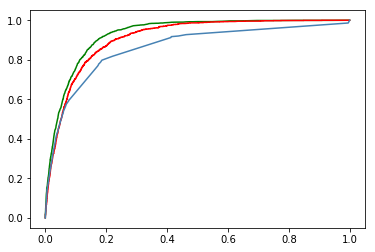

In [156]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
model1 = RandomForestClassifier(random_state=100,n_estimators=1000)
model1.fit(train_x,train_y)
probs1 = pd.DataFrame(model1.predict_proba(test_x),columns=['Neg_1','Pos_2'])
fpr1,tpr1,cutoffs1 = roc_curve(test_y,probs1['Pos_2'],pos_label='yes')
auc_rf =auc(fpr1,tpr1)
plt.plot(fpr1,tpr1,color='green')

print('Random Forest AUC: %.2f' % auc_rf)
from sklearn.ensemble import AdaBoostClassifier
model2 = AdaBoostClassifier(random_state=100)
model2.fit(train_x,train_y)
probs2 = pd.DataFrame(model2.predict_proba(test_x),columns=['Neg_1','Pos_2'])
fpr2,tpr2,cutoffs2 = roc_curve(test_y,probs2['Pos_2'],pos_label='yes')
auc_ab =auc(fpr2,tpr2)
plt.plot(fpr2,tpr2,color='red')

print('Adaptive Boosting AUC: %.2f' % auc_ab)

from sklearn.tree import DecisionTreeClassifier
model3 = DecisionTreeClassifier(random_state=100,max_depth=7)
model3.fit(train_x,train_y)
probs3 = pd.DataFrame(model3.predict_proba(test_x),columns=['Neg_1','Pos_2'])
fpr3,tpr3,cutoffs3 = roc_curve(test_y,probs3['Pos_2'],pos_label='yes')
auc_dt=auc(fpr3,tpr3)
plt.plot(fpr3,tpr3,color='steelblue')
print('Decision Tree AUC: %.2f' % auc_dt)

In [157]:
df_roc = pd.DataFrame({
    'sensitivity': tpr1,
    'specificity': 1- fpr1,
    'cutoff': cutoffs1
})
df_roc['youden_index'] = df_roc['sensitivity'] + df_roc['specificity'] -1
df_roc.sort_values(by='youden_index', ascending=False).head(1)

,cutoff,sensitivity,specificity,youden_index
663,0.125,0.908803,0.821527,0.73033


In [161]:
test_pred_bank = probs1['Pos_2'].apply(lambda v: 'yes' if v>0.12 else 'no')
print(accuracy_score(test_y,test_pred_bank))
print(classification_report(test_y,test_pred_bank))

0.8292539074019464
             precision    recall  f1-score   support

         no       0.99      0.82      0.89     11985
        yes       0.40      0.91      0.55      1579

avg / total       0.92      0.83      0.85     13564

